# Binary Classification with a Bank Churn Dataset


### Challenge Problem:
Goal: the task is to predict whether a customer continues with their account or closes it (e.g., churn.

### Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.





In [4]:
!pip install -q opendatasets
import opendatasets as od
import pandas as pd
from google.colab import drive
drive.mount('./drive')

import os
import json
f = open("/content/drive/MyDrive/Colab Notebooks/kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']


Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [5]:
od.download('https://www.kaggle.com/competitions/playground-series-s4e1/data') # insert  kaggle  username and key


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: asukasaito
Your Kaggle Key: ··········


100%|██████████| 6.81M/6.81M [00:00<00:00, 155MB/s]


Extracting archive ./playground-series-s4e1/playground-series-s4e1.zip to ./playground-series-s4e1


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from PIL import Image


# Data Description:

### About Dataset
The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:

- Customer ID: A unique identifier for each customer
- Surname: The customer's surname or last name
- Credit Score: A numerical value representing the customer's credit score
- Geography: The country where the customer resides (France, Spain or Germany)
- Gender: The customer's gender (Male or Female)
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
- EstimatedSalary: The estimated salary of the customer
- Exited: Whether the customer has churned (1 = yes, 0 = no)


### Files
- train.csv - the training dataset; Exited is the binary target. 12 MB.
- test.csv - the test dataset; your objective is to predict the probability of Exited. 8MB.


In [8]:
# Path to the training images and labels
save_path ='/content/drive/MyDrive/Colab Notebooks/DL_Final/model.h5'

train_path = '/content/playground-series-s4e1/train.csv'
test_path  = '/content/playground-series-s4e1/test.csv'
train = pd.read_csv(train_path)
X_EDA = train.drop(['id','CustomerId','Surname'], axis=1)
test  = pd.read_csv(test_path)
print(train.describe())


                id    CustomerId    CreditScore            Age         Tenure  \
count  165034.0000  1.650340e+05  165034.000000  165034.000000  165034.000000   
mean    82516.5000  1.569201e+07     656.454373      38.125888       5.020353   
std     47641.3565  7.139782e+04      80.103340       8.867205       2.806159   
min         0.0000  1.556570e+07     350.000000      18.000000       0.000000   
25%     41258.2500  1.563314e+07     597.000000      32.000000       3.000000   
50%     82516.5000  1.569017e+07     659.000000      37.000000       5.000000   
75%    123774.7500  1.575682e+07     710.000000      42.000000       7.000000   
max    165033.0000  1.581569e+07     850.000000      92.000000      10.000000   

             Balance  NumOfProducts      HasCrCard  IsActiveMember  \
count  165034.000000  165034.000000  165034.000000   165034.000000   
mean    55478.086689       1.554455       0.753954        0.497770   
std     62817.663278       0.547154       0.430707        0.

#Exploratory Data Analysis

Our exploratory analysis of the training dataset, comprising 165,034 instances, revealed several noteworthy patterns and potential predictors for customer churn:

- The target variable, 'Exited', displays an imbalance with approximately 30,000 instances of churn (Exited=1) against 130,000 instances of retention (Exited=0), highlighting the need for careful consideration of evaluation metrics and potentially resampling techniques during model training.
- A significant portion of the 'Balance' column entries are recorded as zero, suggesting a distinct customer segment that may warrant additional analysis.
- Geographical distribution within the dataset is uneven, with France representing over 80,000 instances, whereas Spain and Germany each account for less than 40,000. This geographical factor could influence the churn rate and should be factored into the analysis.
- Correlation analysis identifies 'Age' as the most positively correlated feature with 'Exited' (correlation coefficient of 0.34), suggesting older customers are more inclined towards churn. Conversely, 'IsActiveMember' and 'NumOfProducts' both demonstrate a negative correlation with 'Exited' (correlation coefficient of -0.21), indicating active members with more products are less likely to churn. These three attributes emerge as prominent factors for predicting churn.
- Breaking down 'Age' further, customers aged 40 or above exhibit a higher propensity for churn compared to younger age groups.
- Analysis of 'Tenure' indicates customers with longer tenure (9 years or more) are less likely to churn, which could reflect a stronger loyalty or satisfaction with the services provided.
- Surprisingly, 'CreditScore' does not exhibit a clear trend with respect to churn, defying the initial hypothesis that creditworthiness might impact customer retention.
- These insights set the stage for in-depth data preprocessing and model development, with an emphasis on addressing the imbalanced nature of the target variable and leveraging the identified key features to predict churn.


In [9]:
# def categorize_age(age):
#     if age < 35:
#         return 'less_35'
#     elif 35 <= age <= 40:
#         return '35-40'
#     elif 40 < age <= 45:
#         return '40-45'
#     else:
#         return 'plus_45'

# def categorize_tenure(tenure):
#     if tenure < 1:
#         return 'less_than_1'
#     elif 1 <= tenure <= 9:
#         return '1-9'
#     else:
#         return 'plus_9'

# # Apply the functions to the respective columns
# train['Age_Group'] = train['Age'].apply(categorize_age)
# train['Tenure_Group'] = train['Tenure'].apply(categorize_tenure)

# # To one-hot encode these new categorical columns, you can use pd.get_dummies
# train = pd.get_dummies(train, columns=['Age_Group', 'Tenure_Group'])
# train = train.drop(['Age', 'Tenure'], axis=1)

# test['Age_Group'] = test['Age'].apply(categorize_age)
# test['Tenure_Group'] = test['Tenure'].apply(categorize_tenure)

# # To one-hot encode these new categorical columns, you can use pd.get_dummies
# test = pd.get_dummies(test, columns=['Age_Group', 'Tenure_Group'])
# test = test.drop(['Age', 'Tenure'], axis=1)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Separate target from predictors
y = train['Exited']

X = train.drop(['Exited', 'id','CustomerId','Surname'], axis=1)
test_X = test.drop(['id','CustomerId','Surname'], axis=1)

# List of categorical columns
categorical_cols = [cname for cname in X.columns if
                    X[cname].nunique() < 10 and
                    X[cname].dtype == "object"]

# List of numerical columns
numerical_cols = [cname for cname in X.columns if
                  X[cname].dtype in ['int64', 'float64']]

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Apply transformations to the data
X_preprocessed = preprocessor.fit_transform(X)
test_X_preprocessed = preprocessor.transform(test_X)

# Splitting the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_preprocessed, y, train_size=0.8, test_size=0.2, random_state=0)


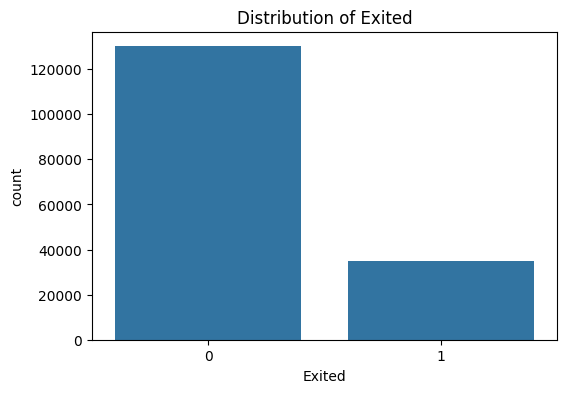

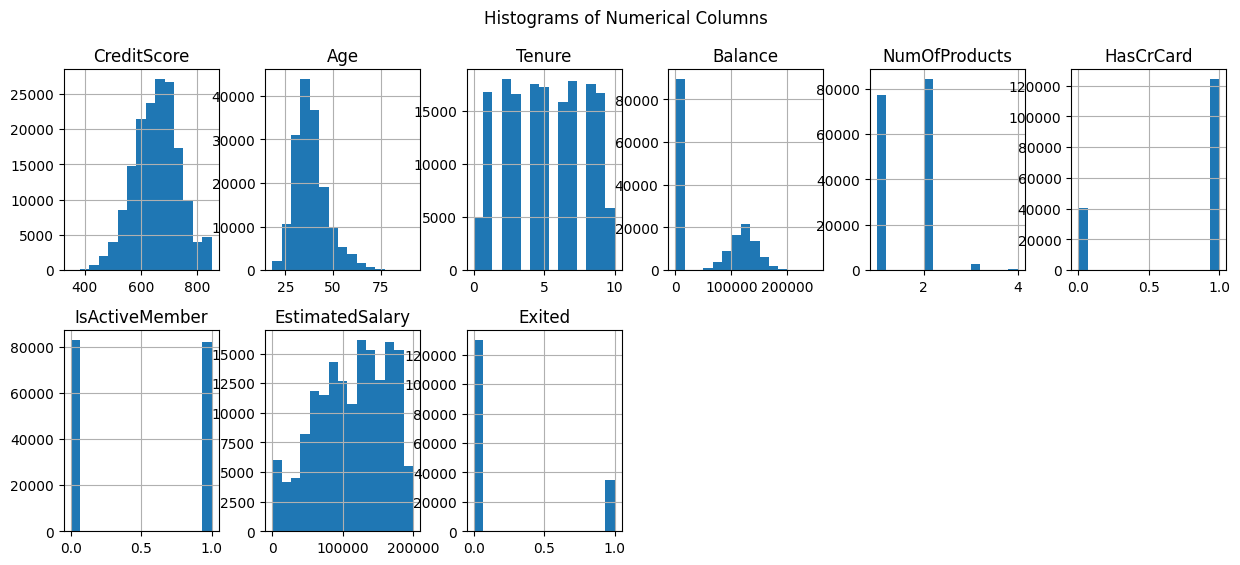

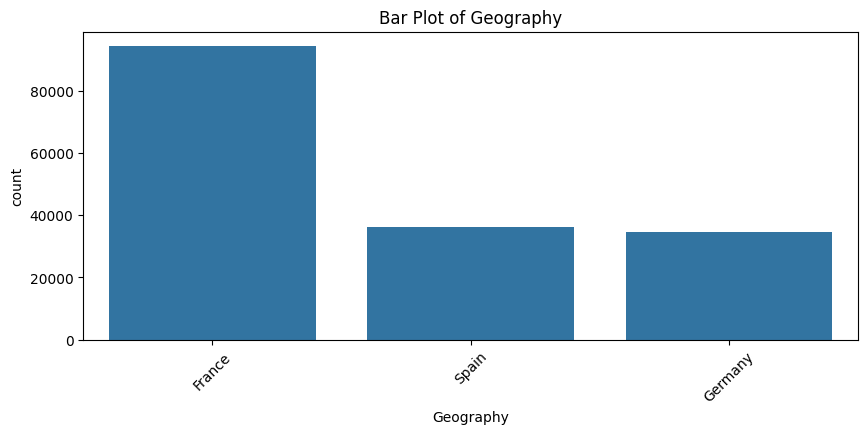

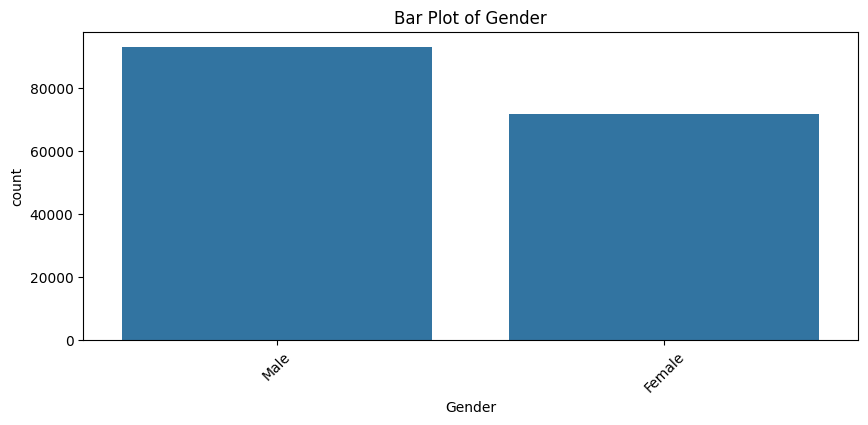

<ipython-input-11-3dd297957406>:24: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(X_EDA.corr(), annot=True, cmap='coolwarm')


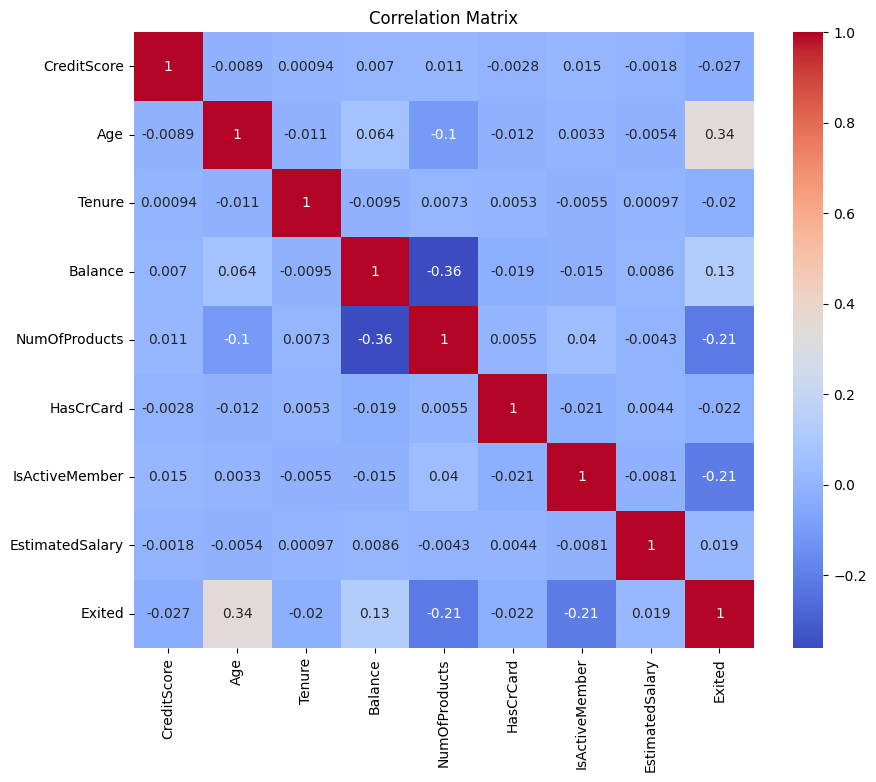

In [11]:
# 1. Distribution of the Target Variable 'Exited'
plt.figure(figsize=(6,4))
sns.countplot(x='Exited', data=X_EDA)
plt.title('Distribution of Exited')
plt.show()

# 2. Histograms for all Numerical Columns
numerical_cols = X_EDA.select_dtypes(include=['int64', 'float64']).columns
X_EDA[numerical_cols].hist(bins=15, figsize=(15, 6), layout=(2, 6))
plt.suptitle('Histograms of Numerical Columns')
plt.show()

# 3. Bar Plots for Categorical Columns
categorical_cols = X_EDA.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=col, data=X_EDA)
    plt.title(f'Bar Plot of {col}')
    plt.xticks(rotation=45)
    plt.show()

# 4. Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X_EDA.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Additional: Pairplot for a Subset of Columns
# Select a few columns for a pairplot
# subset_cols = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary', 'Exited']
# sns.pairplot(X_EDA[subset_cols], hue='Exited')
# plt.show()

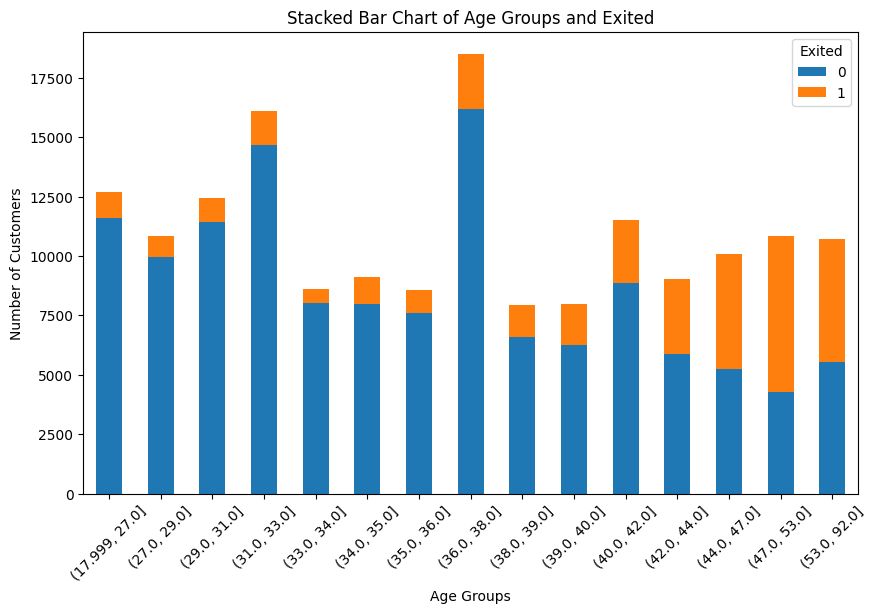

In [12]:

# Grouping CustomerId into bins for better visualization
X_EDA['Age_group'] = pd.qcut(X_EDA['Age'], q=15)

# Counting churned and not churned customers in each group
grouped = X_EDA.groupby(['Age_group', 'Exited']).size().unstack()

# Plotting the stacked bar chart
grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Stacked Bar Chart of Age Groups and Exited')
plt.xlabel('Age Groups')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


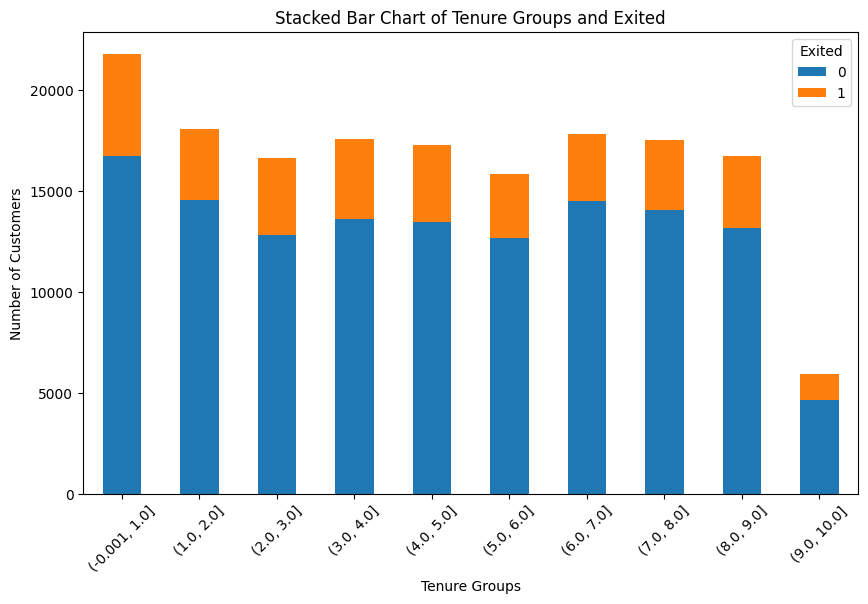

In [13]:

# Grouping CustomerId into bins for better visualization
X_EDA['Tenure_group'] = pd.qcut(X_EDA['Tenure'], q=10)

# Counting churned and not churned customers in each group
grouped = X_EDA.groupby(['Tenure_group', 'Exited']).size().unstack()

# Plotting the stacked bar chart
grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Stacked Bar Chart of Tenure Groups and Exited')
plt.xlabel('Tenure Groups')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


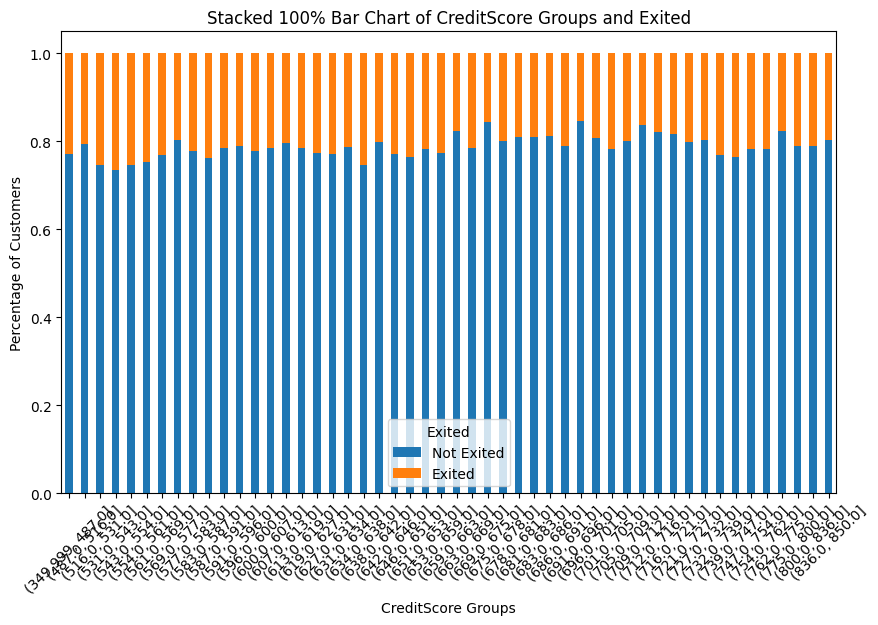

In [14]:

# Grouping CreditScore into bins for better visualization
X_EDA['CreditScore_group'] = pd.qcut(X_EDA['CreditScore'], q=50)

# Counting churned and not churned customers in each group
grouped = X_EDA.groupby(['CreditScore_group', 'Exited']).size().unstack(fill_value=0)

# Normalize the counts to sum to 1 (100%) within each group
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0)

# Plotting the stacked 100% bar chart
grouped_percent.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Stacked 100% Bar Chart of CreditScore Groups and Exited')
plt.xlabel('CreditScore Groups')
plt.ylabel('Percentage of Customers')
plt.xticks(rotation=45)
plt.legend(title='Exited', labels=['Not Exited', 'Exited'])
plt.show()


#Data Preprocessing

In preparation for modeling, we conducted a series of preprocessing steps to refine our dataset:

- Feature Transformation: Our exploratory analysis suggested non-linear relationships between 'Age' and 'Tenure' with the target variable 'Exited'. To better capture these trends, we engineered new categorical features, 'Age_Group' and 'Tenure_Group', delineating age and tenure into discrete ranges that reflect customer lifecycle stages and tenure duration, respectively.

- Feature Reduction: We eliminated the 'CustomerId' and 'Surname' attributes from the dataset. These features were deemed non-predictive as they represent arbitrary identifiers and hold no intrinsic predictive value related to customer churn.

- Missing Value Imputation: We addressed missing data within our dataset by imputing the mean for numerical columns and the most frequent values for categorical columns. This approach maintains data integrity and prepares the dataset for the application of machine learning algorithms.

- Dataset Integration: The analysis determined that joining additional datasets was unnecessary. The existing dataset provides a comprehensive foundation for developing predictive models without the need for external data sources.

#Model Architecture
The development of our model architecture was an iterative process, carefully balanced to suit the nuances of the problem at hand - predicting customer churn. The model's architecture is crucial, as it must effectively capture the patterns within the data while avoiding the pitfalls of overfitting or underfitting.

- Initial Simple Architecture:
We began with a straightforward architecture comprising two hidden layers, each followed by a dropout layer to mitigate overfitting. This model served as a baseline, providing a reference point for the performance of more complex structures.

- Expanded Architecture Exploration:
To explore the model's capacity further, we expanded the architecture to include four hidden layers with a dropout layer, aiming to capture more complex relationships within the data.

- Activation Functions:
The 'ReLU' activation function was employed for hidden layers due to its efficiency and effectiveness in non-linear transformations. For the output layer, we opted for the 'sigmoid' function, appropriate for binary classification tasks, as it outputs probabilities indicating the likelihood of customer churn.

- Optimizer Selection:
The 'Adam' optimizer was chosen for its popularity and proven track record of performance. Adam combines the benefits of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).

- Hyperparameter Tuning:
Initial training was conducted using a batch size of 32 and 100 epochs to establish a baseline. Subsequently, we employed RandomSearch to rigorously test and identify the optimal hyperparameters. This search included experimenting with the number of neurons, dropout rates, learning rates, activation functions, batch sizes, and the number of epochs.

- Comparative Analysis of Architectures:
The two architectures were evaluated based on their ability to predict customer churn accurately. The performance difference provided insights into the complexity required by our model to learn from the dataset effectively.



In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Define the input shape based on the features from your dataset
input_shape = X_train.shape[1]  # Number of features

# Input layer
inputs = keras.Input(shape=(input_shape,))

# Dense layers - Adjust the number of layers and units as needed
# x = layers.Dense(64, activation='relu')(inputs)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.Dropout(0.5)(x)  # Dropout layer to prevent overfitting

x = layers.Dense(128, activation='relu')(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Adjusting dropout rate
x = layers.Dense(64, activation='relu')(x)  # Additional layer
x = layers.Dense(64, activation='relu')(x)  # Additional layer

# Output layer - Using sigmoid activation function for binary classification
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model - Using binary crossentropy as it's a binary classification problem
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])

# Model summary to see the architecture
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 128)               1792      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65    

Epoch 1/100
4126/4126 [==============================] - 12s 3ms/step - loss: 0.3399 - auc: 0.8742 - val_loss: 0.3300 - val_auc: 0.8831
Epoch 2/100
4126/4126 [==============================] - 9s 2ms/step - loss: 0.3293 - auc: 0.8824 - val_loss: 0.3255 - val_auc: 0.8848
Epoch 3/100
4126/4126 [==============================] - 10s 2ms/step - loss: 0.3269 - auc: 0.8844 - val_loss: 0.3230 - val_auc: 0.8870
Epoch 4/100
4126/4126 [==============================] - 10s 2ms/step - loss: 0.3261 - auc: 0.8850 - val_loss: 0.3228 - val_auc: 0.8865
Epoch 5/100
4126/4126 [==============================] - 10s 2ms/step - loss: 0.3252 - auc: 0.8854 - val_loss: 0.3247 - val_auc: 0.8858
Epoch 6/100
4126/4126 [==============================] - 10s 2ms/step - loss: 0.3247 - auc: 0.8861 - val_loss: 0.3232 - val_auc: 0.8863
Epoch 7/100
4126/4126 [==============================] - 9s 2ms/step - loss: 0.3243 - auc: 0.8862 - val_loss: 0.3244 - val_auc: 0.8869
Epoch 8/100
4126/4126 [===========================

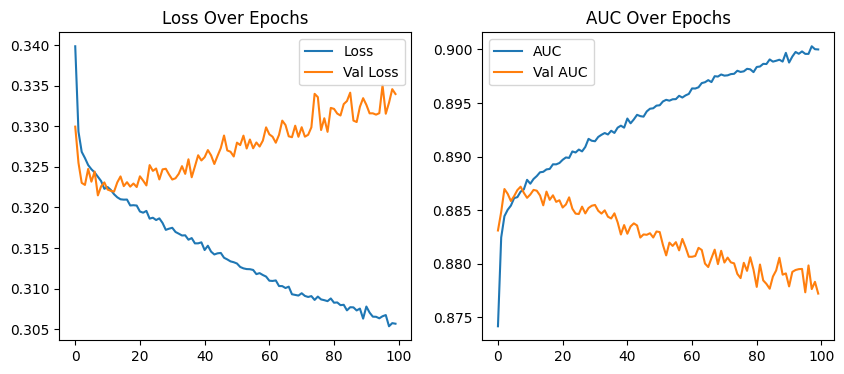

In [16]:

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(save_path, save_best_only=True)

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])


# Evaluate the model on the validation set
val_performance = model.evaluate(X_valid, y_valid)

# You can access the AUC from the history object
auc = history.history['auc']
val_auc = history.history['val_auc']

# Plot the training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend()
plt.title('AUC Over Epochs')
plt.show()


In [17]:
model.save(save_path)

# To load the model back in, you would use:
loaded_model = tf.keras.models.load_model(save_path)

In [18]:

# Make predictions on the test set
test_predictions = model.predict(test_X_preprocessed)

# Since we are interested in probabilities, ensure the predictions are in the correct format
test_predictions = test_predictions.squeeze()  # This removes any unnecessary dimensions from the predictions

# Prepare the submission DataFrame
submission_df = pd.DataFrame({'id': test['id'], 'Exited': test_predictions})

# Save the submission file
submission_path = '/content/drive/MyDrive/Colab Notebooks/DL_Final/submission.csv'
submission_df.to_csv(submission_path, index=False)

print("Submission file saved to: ", submission_path)


3439/3439 [==============================] - 4s 1ms/step
Submission file saved to:  /content/drive/MyDrive/Colab Notebooks/DL_Final/submission.csv


In [19]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Function to create model, required for KerasClassifier
def create_model(neurons=16, dropout_rate=0.0, learning_rate=0.001, activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(input_shape,), activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Wrap Keras model into KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=1)

# Define the grid search parameters
param_grid = {
    'neurons': [16, 32, 64, 128],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32, 64],
    'epochs': [10, 50, 100]
}

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3, n_iter=10, scoring='roc_auc')

# Fit RandomizedSearchCV
random_search_result = random_search.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))


<ipython-input-19-7a4a54e199f2>:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=1)


Epoch 1/50
2063/2063 [==============================] - 4s 1ms/step - loss: 0.3391 - accuracy: 0.8577
Epoch 2/50
2063/2063 [==============================] - 3s 1ms/step - loss: 0.3285 - accuracy: 0.8626
Epoch 3/50
2063/2063 [==============================] - 3s 1ms/step - loss: 0.3277 - accuracy: 0.8631
Epoch 4/50
2063/2063 [==============================] - 3s 1ms/step - loss: 0.3271 - accuracy: 0.8637
Epoch 5/50
2063/2063 [==============================] - 3s 1ms/step - loss: 0.3261 - accuracy: 0.8641
Epoch 6/50
2063/2063 [==============================] - 3s 1ms/step - loss: 0.3260 - accuracy: 0.8638
Epoch 7/50
2063/2063 [==============================] - 3s 1ms/step - loss: 0.3258 - accuracy: 0.8636
Epoch 8/50
2063/2063 [==============================] - 3s 1ms/step - loss: 0.3256 - accuracy: 0.8638
Epoch 9/50
2063/2063 [==============================] - 3s 1ms/step - loss: 0.3254 - accuracy: 0.8633
Epoch 10/50
2063/2063 [==============================] - 3s 1ms/step - loss: 0.325

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 32)                384       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                1056      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2063/2063 [==============================] - 4s 2ms/step - loss: 0.4038 - auc: 0.8148 - val_loss: 0.3763 - val_auc: 0.8410
Epoch 2/10
2063/2063 [============================

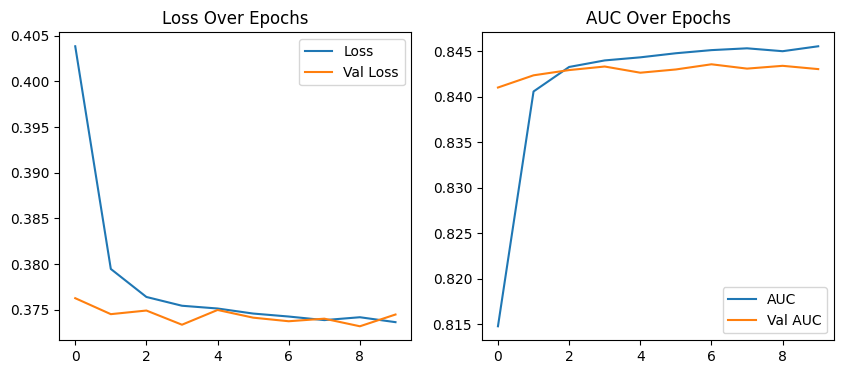

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assign the best hyperparameters to variables
best_neurons = 32
best_dropout_rate = 0.3
best_learning_rate = 0.001
best_activation = 'tanh'
best_batch_size = 64
best_epochs = 10

# Rebuild the model with the best hyperparameters
model = Sequential()
model.add(Dense(best_neurons, input_shape=(input_shape,), activation=best_activation))
model.add(Dropout(best_dropout_rate))
model.add(Dense(best_neurons, activation=best_activation))
model.add(Dense(1, activation='sigmoid'))  # Output layer
optimizer = Adam(learning_rate=best_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.AUC(name='auc')])

# Model summary to see the new architecture
model.summary()

# Train the model with the best hyperparameters
history = model.fit(X_train, y_train,
                    batch_size=best_batch_size,
                    epochs=best_epochs,
                    validation_data=(X_valid, y_valid))

# Evaluate the model on the validation set with the new hyperparameters
val_performance = model.evaluate(X_valid, y_valid)

# Plot the training history if desired
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend()
plt.title('AUC Over Epochs')
plt.show()


#Results and Analysis

This table show the summary.

| Model                      | Kaggle AUC|
|----------------------------|:---------:|
| Baseline ( 2 hidden)       |    .88229 |
| Baseline+ ( 4 hidden)      |    .87295 |
| Baseline (Random Tuned)    |    .88216 |
| Baseline (Data augmented)  | .88028    |
| Baseline (Feature Tuned )  | .84272    |


Several approaches were tested to improve the accuracy of our predictions:

- Initial Model Approach: The first model, built with two hidden layers, achieved an AUC score of 0.88229 on Kaggle. This was a promising start, suggesting that our basic model was on the right track.

- Experimenting with More Layers: In an attempt to improve our model, we increased its complexity by adding two more hidden layers. However, this approach resulted in a slightly lower score of 0.87295, indicating that additional complexity did not necessarily lead to better predictions.

- Hyperparameter Tuning with RandomSearch: We then used RandomSearch to optimize the model's settings, like the number of neurons and the learning rate. This method fine-tuned our model but the AUC score remained similar to the initial model, at 0.88216, showing that even the 'best' settings did not significantly outperform our original approach.

- Data Augmentation Attempt: Another strategy involved using an additional dataset provided by Kaggle to enhance our model's learning. Surprisingly, this did not improve our results, and the AUC score slightly decreased to 0.88028. This suggested that simply adding more data was not enough to make better predictions.

- Feature Engineering with Age and Tenure Groups: Finally, we tried to improve our model by categorizing customers into different age and tenure groups. Contrary to our expectations, this modification led to a decrease in performance, with an AUC score of 0.84272. It seemed that our initial model was already effectively capturing the necessary information from these features.

In conclusion, through this project, we learned that a more complex model does not always guarantee better results. Sometimes, a simpler model can capture the essence of the data effectively. This project was a valuable exercise in understanding the nuances of model building and the importance of matching model complexity with the patterns inherent in the data.

In [89]:
save_path_r ='/content/drive/MyDrive/Colab Notebooks/DL_Final/model_r.h5'
model.save(save_path_r)

# To load the model back in, you would use:
loaded_model = tf.keras.models.load_model(save_path_r)

# Make predictions on the test set
test_predictions = model.predict(test_X_preprocessed)

test_predictions = test_predictions.squeeze()  # This removes any unnecessary dimensions from the predictions

# Prepare the submission DataFrame
submission_df = pd.DataFrame({'id': test['id'], 'Exited': test_predictions})

# Save the submission file
submission_path = '/content/drive/MyDrive/Colab Notebooks/DL_Final/submission_r.csv'
submission_df.to_csv(submission_path, index=False)

print("Submission file saved to: ", submission_path)


3439/3439 [==============================] - 3s 914us/step
Submission file saved to:  /content/gdrive/MyDrive/Colab Notebooks/DL_Final/submission_r.csv


In [90]:
newdf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL_Final/Churn_Modelling.csv')

In [91]:
from sklearn.utils import shuffle

# Combine the datasets
combined_df = pd.concat([train, newdf], ignore_index=True)

# Shuffle the combined dataset to ensure a good mix of data points
combined_df = shuffle(combined_df, random_state=0)

In [92]:
# Separate target from predictors
y_c = combined_df['Exited']
X_c = combined_df.drop(['Exited', 'id','CustomerId','Surname'], axis=1)

# Apply transformations to the data
X_preprocessed_c = preprocessor.fit_transform(X_c)

# Splitting the dataset into training and validation sets
X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(X_preprocessed_c, y_c, train_size=0.8, test_size=0.2, random_state=0)

Epoch 1/100
4376/4376 [==============================] - 8s 2ms/step - loss: 0.3762 - auc: 0.8417 - val_loss: 0.3723 - val_auc: 0.8460
Epoch 2/100
4376/4376 [==============================] - 8s 2ms/step - loss: 0.3760 - auc: 0.8421 - val_loss: 0.3720 - val_auc: 0.8467
Epoch 3/100
4376/4376 [==============================] - 7s 2ms/step - loss: 0.3758 - auc: 0.8423 - val_loss: 0.3725 - val_auc: 0.8462
Epoch 4/100
4376/4376 [==============================] - 7s 2ms/step - loss: 0.3757 - auc: 0.8422 - val_loss: 0.3723 - val_auc: 0.8459
Epoch 5/100
4376/4376 [==============================] - 8s 2ms/step - loss: 0.3754 - auc: 0.8425 - val_loss: 0.3721 - val_auc: 0.8461
Epoch 6/100
4376/4376 [==============================] - 7s 2ms/step - loss: 0.3757 - auc: 0.8422 - val_loss: 0.3719 - val_auc: 0.8460
Epoch 7/100
4376/4376 [==============================] - 8s 2ms/step - loss: 0.3751 - auc: 0.8428 - val_loss: 0.3718 - val_auc: 0.8463
Epoch 8/100
4376/4376 [==============================] 

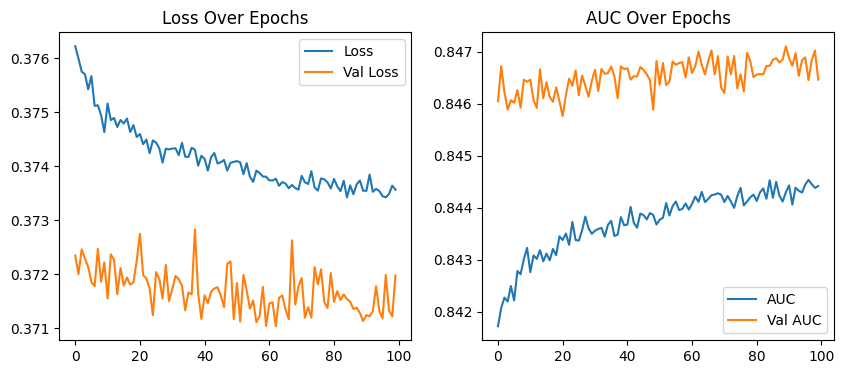

In [93]:

save_path_c ='/content/drive/MyDrive/Colab Notebooks/DL_Final/model_c.h5'
checkpoint_cb_c = tf.keras.callbacks.ModelCheckpoint(save_path_c, save_best_only=True)

# Train the model
history = model.fit(X_train_c, y_train_c,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_valid_c, y_valid_c),
                    callbacks=[checkpoint_cb_c])


# Evaluate the model on the validation set
val_performance_c = model.evaluate(X_valid_c, y_valid_c)

# You can access the AUC from the history object
auc = history.history['auc']
val_auc = history.history['val_auc']

# Plot the training history if you want to visualize the training process
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend()
plt.title('AUC Over Epochs')
plt.show()


In [95]:
model.save(save_path_c)

# To load the model back in, you would use:
loaded_model = tf.keras.models.load_model(save_path_c)

# Make predictions on the test set
test_predictions = model.predict(test_X_preprocessed)

test_predictions = test_predictions.squeeze()  # This removes any unnecessary dimensions from the predictions

# Prepare the submission DataFrame
submission_df = pd.DataFrame({'id': test['id'], 'Exited': test_predictions})

# Save the submission file
submission_path = '/content/drive/MyDrive/Colab Notebooks/DL_Final/submission_c.csv'
submission_df.to_csv(submission_path, index=False)

print("Submission file saved to: ", submission_path)


3439/3439 [==============================] - 3s 859us/step
Submission file saved to:  /content/gdrive/MyDrive/Colab Notebooks/DL_Final/submission_c.csv


#Conclusion

In this project, our purpose was to develop a predictive model to identify potential customer churn for a bank, utilizing various data-driven approaches. The evaluation metric guiding our efforts was the area under the ROC curve (AUC), a robust indicator of model performance in binary classification tasks.

- Throughout this journey, we experimented with several methodologies, including hyperparameter tuning, building more complex neural network models, and augmenting our dataset with additional data. However, the most striking revelation was the effectiveness of our simpler initial model, which often outperformed more sophisticated approaches. This outcome suggests that sometimes straightforward models can be quite powerful, particularly when the underlying data structure is not exceedingly complex.

- One key takeaway is the importance of understanding the data and the problem context deeply. While deep learning offers powerful tools, it is not always the most suitable approach, especially if the underlying data patterns are not sufficiently complex to warrant such models. Our best AUC score was 0.88229, quite close to the top Kaggle score of 0.90180, suggesting that our model was competitive but perhaps constrained by the inherent simplicity of the dataset.

Looking forward, there are several avenues to explore for improvement:

- Ensemble Methods: Combining predictions from multiple models could yield better results. Ensemble techniques often enhance predictive performance by leveraging the strengths of various approaches.

- Supervised Machine Learning: Given the apparent simplicity of the data structure, traditional supervised learning algorithms, like decision trees or gradient boosting machines, might be more effective and should be explored.

- Feature Engineering: There may be room for more creative feature engineering. Understanding domain-specific nuances and integrating this knowledge into the feature design could uncover new predictive patterns.

- Data Collection: Additional data, particularly more diverse or domain-specific features, might enhance the model's understanding and predictive capabilities.

In conclusion, this project was a valuable exercise in both the strengths and limitations of various modeling approaches. It underscored the importance of aligning model complexity with data characteristics and highlighted the need for continuous exploration and adaptation in data science projects.